# Credit Card Fraud Detection

End-to-end notebook: EDA → preprocessing → training → evaluation → threshold tuning.


In [1]:

# Imports
import os, json, datetime, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Repro
np.random.seed(42)
plt.rcParams["figure.figsize"] = (7,5)


In [2]:

# Locate dataset: try user path, relative path, then /mnt/data
CANDIDATE_PATHS = [
    "/Users/tanjimhossain/Documents/creditcard.csv",
    "creditcard.csv",
    "/mnt/data/creditcard.csv"
]

def pick_first_existing(paths):
    import os
    for p in paths:
        if os.path.exists(p):
            print("Using data at:", p)
            return p
    print("WARNING: None of the candidate paths exist. Update CANDIDATE_PATHS.")
    return paths[0]

data_path = pick_first_existing(CANDIDATE_PATHS)
df = pd.read_csv(data_path)
df.head()


Using data at: /Users/tanjimhossain/Documents/creditcard.csv


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Shape: (284807, 31)
Time    float64
V1      float64
V2      float64
V3      float64
V4      float64
dtype: object

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


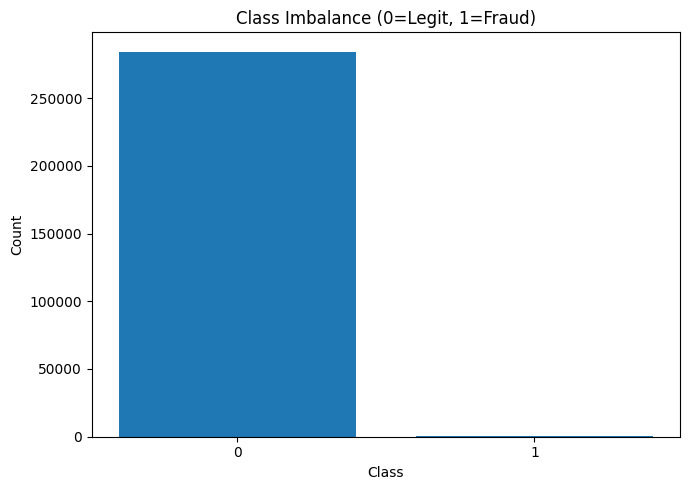

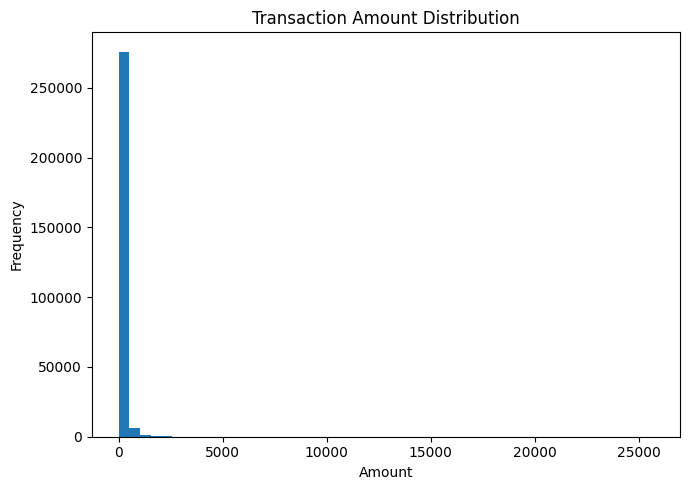

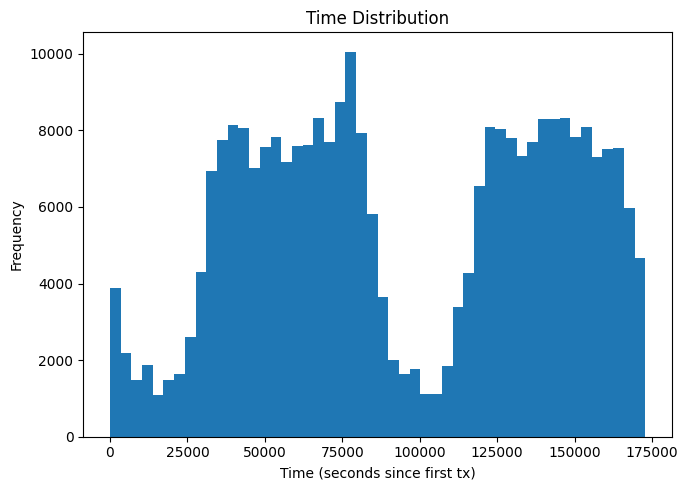

In [3]:

# Basic info
print("Shape:", df.shape)
print(df.dtypes.head())
print("\nClass distribution:")
print(df["Class"].value_counts())

# Plot class imbalance
counts = df["Class"].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Imbalance (0=Legit, 1=Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Amount and Time distributions
fig = plt.figure()
plt.hist(df["Amount"], bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

fig = plt.figure()
plt.hist(df["Time"], bins=50)
plt.title("Time Distribution")
plt.xlabel("Time (seconds since first tx)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


In [4]:

# Train/Test split (stratified)
y = df["Class"].astype(int).values
X = df.drop(columns=["Class"])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y[train_idx], y[test_idx]

X_train.shape, X_test.shape


((227845, 30), (56962, 30))

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

def make_pipe(clf):
    return ImbPipeline(steps=[
        ("pre", pre),
        ("smote", SMOTE(sampling_strategy=0.05, k_neighbors=3, random_state=42)),  # 5% of majority
        ("clf", clf),
    ])


Best model: rf ROC-AUC: 0.9564187520815868 AP: 0.8495877483392605


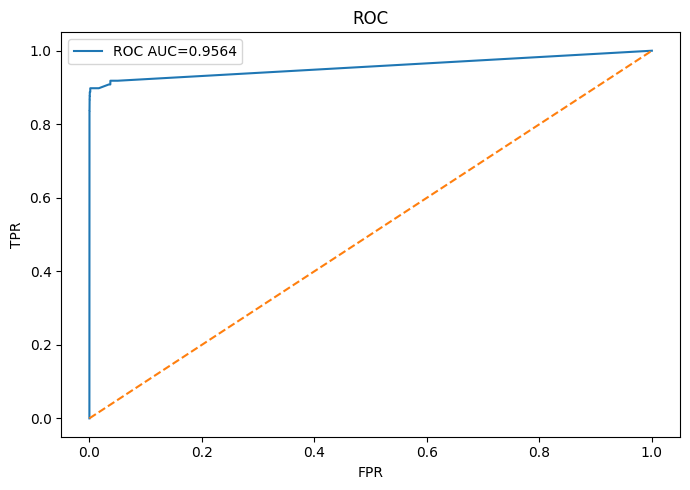

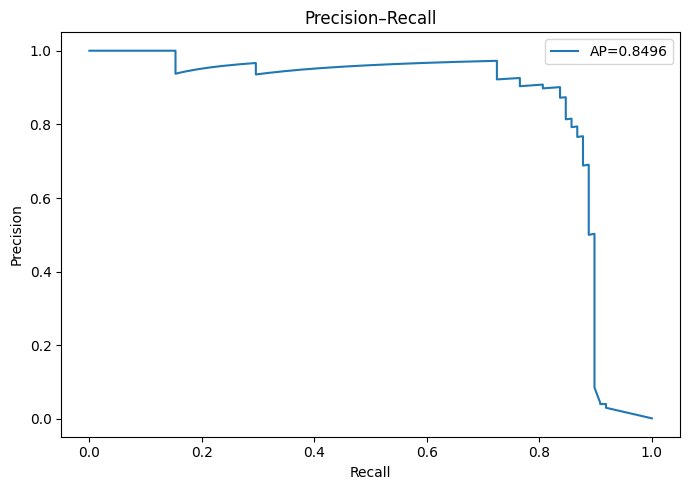

In [6]:
# Requires df loaded with 'Class' column
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)

# Split
y = df["Class"].astype(int).values
X = df.drop(columns=["Class"])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr, te = next(sss.split(X, y))
X_train, X_test, y_train, y_test = X.iloc[tr], X.iloc[te], y[tr], y[te]

# Preprocess
pre = ColumnTransformer([("num", StandardScaler(), ["Amount","Time"])],
                        remainder="passthrough")

# Models (fast settings)
algs = {
    "logreg": LogisticRegression(max_iter=200, solver="lbfgs", class_weight="balanced"),
    "rf": RandomForestClassifier(n_estimators=150, max_depth=18, max_samples=0.5,
                                 n_jobs=-1, random_state=42, class_weight="balanced_subsample"),
}

def make_pipe(clf): return Pipeline([("pre", pre), ("clf", clf)])

# Train & score both
scores = {}
for name, clf in algs.items():
    pipe = make_pipe(clf).fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    scores[name] = {"roc": roc_auc_score(y_test, proba),
                    "ap": average_precision_score(y_test, proba),
                    "pipe": pipe, "proba": proba}

# Pick best by AP and plot
best = max(scores.items(), key=lambda kv: kv[1]["ap"])[0]
best_pipe = scores[best]["pipe"]
proba_test = scores[best]["proba"]
print("Best model:", best, "ROC-AUC:", scores[best]["roc"], "AP:", scores[best]["ap"])

fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(); plt.plot(fpr,tpr,label=f"ROC AUC={scores[best]['roc']:.4f}")
plt.plot([0,1],[0,1],"--"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure(); plt.plot(rec,prec,label=f"AP={scores[best]['ap']:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend(); plt.tight_layout(); plt.show()


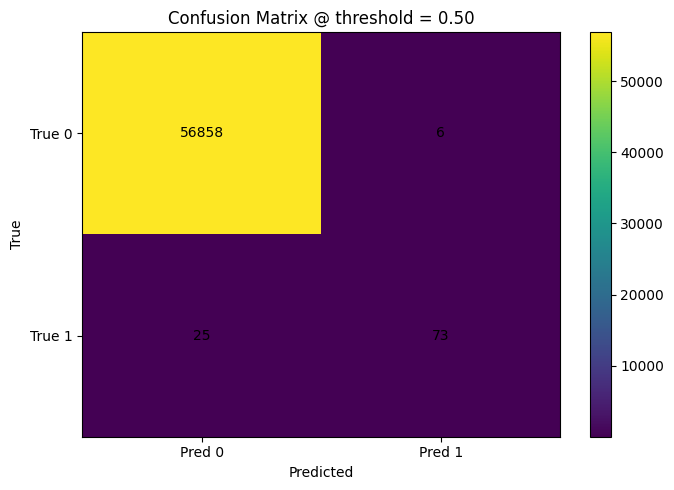

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# assumes you already have y_test and proba_test
y_pred = (proba_test >= 0.50).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm, interpolation="nearest", aspect="auto")
plt.title("Confusion Matrix @ threshold = 0.50")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Pred 0","Pred 1"])
plt.yticks(ticks, ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()


In [8]:

# Threshold tuning by F1
def best_threshold_by_f1(y_true, proba):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    thresholds = np.append(thresholds, 1.0)
    f1 = (2*precision*recall)/(precision+recall+1e-12)
    idx = np.nanargmax(f1)
    return thresholds[idx], f1[idx]

opt_thr, opt_f1 = best_threshold_by_f1(y_test, proba_test)
print("Best threshold by F1:", opt_thr, "F1:", opt_f1)

y_pred_opt = (proba_test >= opt_thr).astype(int)
print("Confusion matrix @opt:", confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt, digits=4))


Best threshold by F1: 0.3333244981377981 F1: 0.8677248677243683
Confusion matrix @opt: [[56855     9]
 [   16    82]]
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.9011    0.8367    0.8677        98

    accuracy                         0.9996     56962
   macro avg     0.9504    0.9183    0.9338     56962
weighted avg     0.9995    0.9996    0.9996     56962



In [9]:

# Save the trained pipeline and metadata
from joblib import dump
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True, parents=True)

dump(best_pipe, models_dir / "model.joblib")

meta = {
    "algo": best,
    "trained_at": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "roc_auc_test": float(roc_auc_score(y_test, proba_test)),
    "average_precision_test": float(average_precision_score(y_test, proba_test)),
    "features": list(X.columns)
}
(Path("../models") / "metadata.json").write_text(json.dumps(meta, indent=2))
meta


{'algo': 'rf',
 'trained_at': '2025-08-08 21:58:47',
 'roc_auc_test': 0.9564187520815868,
 'average_precision_test': 0.8495877483392605,
 'features': ['Time',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8',
  'V9',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V15',
  'V16',
  'V17',
  'V18',
  'V19',
  'V20',
  'V21',
  'V22',
  'V23',
  'V24',
  'V25',
  'V26',
  'V27',
  'V28',
  'Amount']}